In [4]:
import matplotlib.pyplot as plt
from math import *
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from datetime import date
import time
import matplotlib.dates as mdates



In [169]:
# Importing data 
cols = ['dt_referencia', 'confirmados', 'recuperados', 'obitos']

df = pd.read_csv('./PE-data.csv', usecols=cols)
df.filter

initial_date = date(2020, 7, 1)
end_date = date(2021, 10, 31)
forecast_date = date(2022, 2, 28)
unix_inital_date = time.mktime(initial_date.timetuple())
unix_end_date = time.mktime(end_date.timetuple())


datetime_series = pd.to_datetime(df['dt_referencia'])

segs_per_d = 24 * 60 * 60

datetime_index = pd.DatetimeIndex(datetime_series.values)

df=df.set_index(datetime_index)
print(type(datetime_index))

df.drop('dt_referencia',axis=1,inplace=True)

df = df.loc['2020-07-01':'2021-10-31']

real_total_pop = 9.278E6

n_days = (end_date - initial_date).days
n_days_forecast = (forecast_date - initial_date).days
# forècaz 28/02/2022

t = np.array(list(range(0, n_days+1)))
r = pd.date_range(start=initial_date, end=end_date)

tf = np.array(list(range(0, n_days_forecast+1)))
rf = pd.date_range(start=initial_date, end=forecast_date)
df

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,confirmados,obitos,recuperados
2020-07-01,61119,4968,41925
2020-07-02,62362,5068,42456
2020-07-03,63457,5116,44314
2020-07-04,65129,5143,44568
2020-07-05,65642,5163,46417
...,...,...,...
2021-10-27,630520,19990,568818
2021-10-28,630980,20001,569115
2021-10-29,631632,20007,569986
2021-10-30,631892,20018,570246


# Abstract
This is a numerical analysis about COVID-19 in Pernambuco. It's going to model the behaviour of the pandemic between 01/07/2020 and 31/10/2021 and forecast the evolution of the pandemic up to 28/02/2022. We wil use a mix between the SIRV and SIRS model with vital dynamics.

# Introduction and Objectives
The COVID-19 pandemic has changed an taken the lives of many people. Being able to forecast and test the outcome of different measures to contain the disease is fundamental to it's erradication and control.
This is why a Numerical Model is so important in this scenario because it's a transparent sandbox where it's possible to test many different measures and alternative realities.

We expect our model to be able to fit the historical data in Pernambuco about the COVID-19 pandemic and then create a _reasonable_ forecast. We also plan to tweak different parameters and see what would happen in those scenarios such as varying $\beta$ (the effective contamination) to model the use of masks.


# Methods
In this draft we are going to model the pandemic with the basic $SIR$ model and we will compare the graph of this model to the actual historical data to tune the $\beta$ and $\gamma$ parameters. We'll also use real data about Pernambuco's population for the $S$, $I$, $R$ values. 


The $SIR$ model:
$$
\begin{align*}
S &= -\beta SI  \\
I &= \beta SI - \gamma I \\
R &= \gamma I \\
\end{align*}
$$

Which in `python` code is as follows:

### Simplified $SIR$ model

In [6]:
def SIR(u, t):

    N = real_total_pop

    S = u[0]
    I = u[1]
    R = u[2]

    beta = 0.08 / N
    gamma = 0.0785

    return [-beta*S*I, beta*S*I - gamma*I, gamma*I]


Those `beta` and `gamma` parameters were tuned by hand to match the real data.


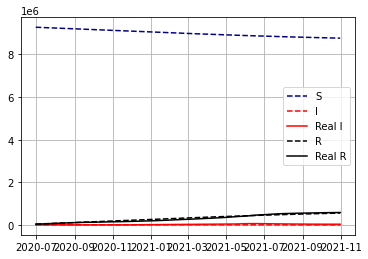

In [7]:
model_pop = real_total_pop 
model_infected = (61119 - (41925 + 4968)) / real_total_pop
model_recovered = (41925 + 4968) / real_total_pop
u = [model_pop - (model_pop * model_infected), model_pop * model_infected, model_pop * model_recovered]

solution = odeint(SIR, u, t)
S = solution[:, 0]
I = solution[:, 1]
R = solution[:, 2]

plt.grid()
plt.plot(r, S, label="S", color="darkblue", linestyle="dashed")
plt.plot(r, I, label="I", color="red", linestyle="dashed")
plt.plot(df['confirmados'] - (df['obitos'] + df['recuperados']), label="Real I", color="red")
plt.plot(r, R, label="R", color="black", linestyle="dashed")
plt.plot(df['obitos'] + df['recuperados'], label="Real R", color="black")
plt.legend()
plt.show()
#plt.plot(t,odeint(SIR, u, t)[:, 1])

Now plotting just the $I$ and the $R$ for better detail

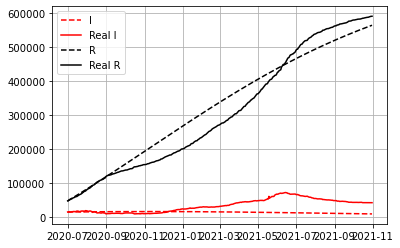

In [8]:
plt.grid()
#plt.plot(r, S, label="S", color="darkblue", linestyle="dashed")
plt.plot(r, I, label="I", color="red", linestyle="dashed")
plt.plot(df['confirmados'] - (df['obitos'] + df['recuperados']), label="Real I", color="red")
plt.plot(r, R, label="R", color="black", linestyle="dashed")
plt.plot(df['obitos'] + df['recuperados'], label="Real R", color="black")
plt.legend()
plt.show()

### Final $SEIR$ model

For the final paper we'll use a more sophisticated model for the pandemic. It's the $SEIR$ model, which takes into account _vital dynamics_ (people being born and dying of natural causes). It also has a different state where a person can be: _Exposed_, which they can die or become infected.

$$
\begin{align*}

\frac{dS}{dt} &= \mu N - \mu S - \frac{\beta IS}{N} \\ \\
\frac{dE}{dt} &= \frac{\beta IS}{N} - (\mu + a)E \\ \\
\frac{dI}{dt} &= a E - (\gamma + \mu) I \\ \\
\frac{dR}{dt} &= \gamma I - \mu R \\ \\


\end{align*}
$$

We'll also assume that the birth rate and death rate are the same. But this doesn't make the vital dynamics useless because it feeds constantly with fresh new Succeptible people.

This translates to this Python code:

In [204]:
def SEIR(u, t):

    N = real_total_pop

    S = u[0]
    E = u[1]
    I = u[2]
    R = u[3]

    beta = 0.074 / N
    gamma = 1/18. # Infecctious period https://www.nature.com/articles/s41467-020-20568-4
    mu = 0.0028
    a = 1/14. # Time that a person takes to become infecctious
    return [
        mu*N - mu*S - beta*S*I,
        beta*S*I - (mu + a) * E,
        a*E - (gamma + mu) * I,
        gamma*I - mu*R,
    ]


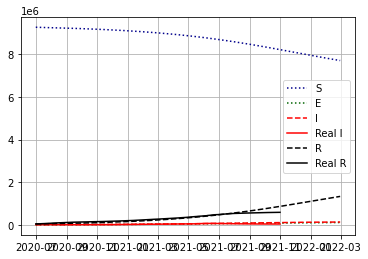

In [209]:
u = [model_pop - (model_pop * model_infected),0, model_pop * model_infected,model_pop * model_recovered]
solution = odeint(SEIR, u, tf)
S = solution[:, 0]
E = solution[:, 1]
I = solution[:, 2]
R = solution[:, 3]

plt.grid()
plt.plot(rf, S, label="S", color="darkblue", linestyle="dotted")
plt.plot(rf, E, label="E", color="darkgreen", linestyle="dotted")
plt.plot(rf, I, label="I", color="red", linestyle="dashed")
plt.plot(df['confirmados'] - (df['obitos'] + df['recuperados']), label="Real I", color="red")
plt.plot(rf, R, label="R", color="black", linestyle="dashed")
plt.plot(df['obitos'] + df['recuperados'], label="Real R", color="black")
#plt.plot(df['confirmados'] - (df['obitos'] + df['recuperados']), label="Real I", color="red")
#plt.plot(r, R, label="R", color="black", linestyle="dashed")
#plt.plot(df['obitos'] + df['recuperados'], label="Real R", color="black")
plt.legend()
plt.show()

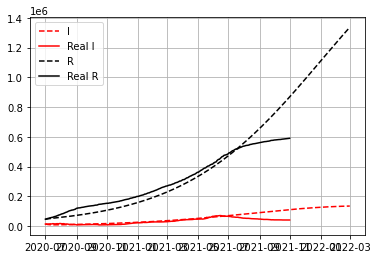

In [210]:

plt.grid()
plt.plot(rf, I, label="I", color="red", linestyle="dashed")
plt.plot(df['confirmados'] - (df['obitos'] + df['recuperados']), label="Real I", color="red")
plt.plot(rf, R, label="R", color="black", linestyle="dashed")
plt.plot(df['obitos'] + df['recuperados'], label="Real R", color="black")
plt.legend()
plt.show()

This model also forecasts the direction which the pandemic is going up to 28/02/2022.

The difference in the latter days can be explained by the reduction of $\beta$ with the start of the vaccination of the population and quarantines imposed by Pernambuco's government.

# Results and Discussion
### Error
### Forecast
### Interesting findings
The $SEIR$ model with populational dynamics (in some configuration of parameters) presents an oscilatory behaviour similiar to a second order differential equation with damping.

# Conclusion
In this project we saw how diffential equations can be really useful in the modeling process of dynamical systems. It was also really rewarding to tweak the model and understand every bit of it's inner workings and still be surprised by the solutions presented.

We think that differential models are a really valuable tool is this field, but it's easy to see many different applications as well. With a good enough model (specially with the correct variation of $\beta$)